Michael Muschitiello // Run & Autocorrelation-Analysis, and European Option Pricing with Monte Carlo Methods

Part 1: 
- Discuss the observed market behavior of BTC, noting that the price action is generally trend-following with occasional mean reversion.
- Highlight that overall, the time series data does not exhibit long-term mean reversion.
- Prepare the dataset and perform initial exploratory analysis.

Part 2:
- Demonstrate how to price both vanilla and digital European call options using Monte Carlo simulations under three different sampling approaches:
1. Sampling the terminal stock price, Sₜ, directly (lognormal distribution).
2. Sampling the log of the terminal stock price, Xₜ (normal distribution).
3. Sampling in CDF space, Yₜ, which follows a uniform distribution in [0, 1].

All methods are compared against the analytical Black–Scholes formula to verify accuracy.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm

# Part 1

In [2]:
btc = pd.read_csv('BTC-USD.csv')
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
btc_rets = pd.DataFrame(btc['Adj Close'].pct_change().dropna())
btc_rets.head()

,Adj Close
1,-0.071926
2,-0.069843
3,0.035735
4,-0.024659
5,0.008352


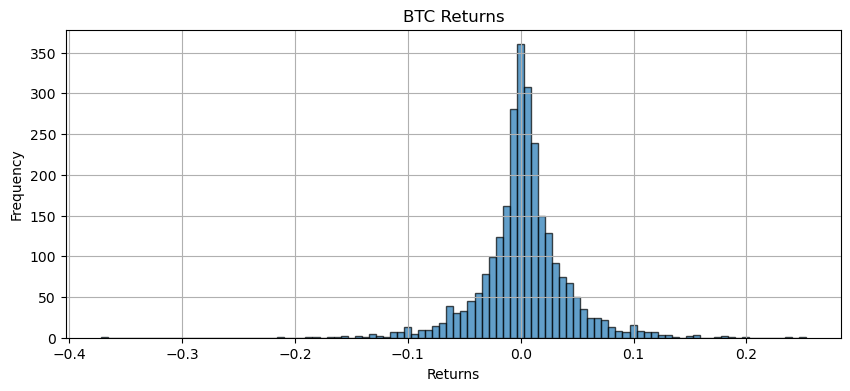

In [4]:
plt.figure(figsize=(10,4))
plt.hist(btc_rets, bins = 100, edgecolor = 'k', alpha = 0.7)
plt.title('BTC Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram of daily btc returns looks normally distributed.

In [ ]:
# skewness
skewness = stats.skew(btc_rets)

# excess Kurtosis (Kurtosis - 3)(3=kurtosis of normal distribution)
kurtosis = stats.kurtosis(btc_rets)

print(f'Skewness: {skewness}')
print(f'Kurtosis: {kurtosis}')

Skewness: [-0.15219491]
Kurtosis: [7.29901211]


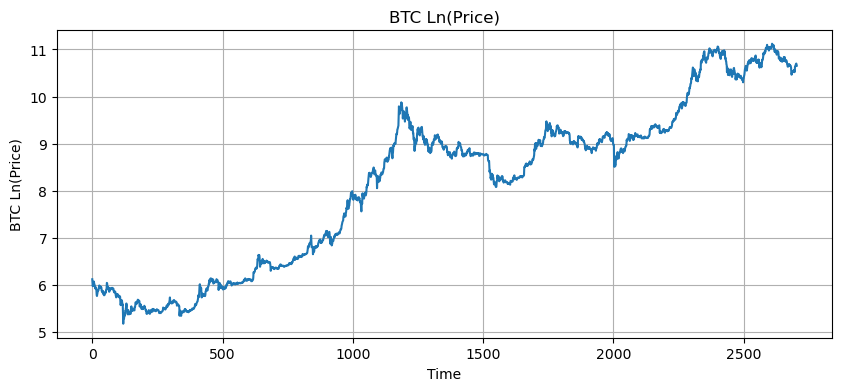

In [6]:
log_btc = np.log(btc['Adj Close'])

plt.figure(figsize=(10,4))
plt.plot(log_btc)
plt.title('BTC Ln(Price)')
plt.xlabel('Time')
plt.ylabel('BTC Ln(Price)')
plt.grid(True)
plt.show()

The price action is trend-following, with smaller periods of mean reversion. Certainly not mean-reverting through time. 

In [7]:
log_btc = pd.DataFrame(log_btc)
log_btc.head()

,Adj Close
0,6.125414
1,6.050771
2,5.978369
3,6.013480
4,5.988513


Carrying out the runs test on the return series in mean-reverting period: 1000:2000
and Trend following period: 0:1200, 2000:

- If the returned z-score from runs_statistic < 1.96, we accept that the periods returns were generated independently

In [8]:
def sequence_runs(S):
    """
    Calculate the number of runs in the sequence S.
Parameters:
    S (list or array-like): The input sequence.
Returns:
    int: The number of runs in the sequence.

    A run is a sequence of consecutive elements that are either all increasing or all decreasing.
    """
    slope=np.sign(np.diff(S))
    turns=( slope[:-1]!=slope[1:]) # compare sequence to sequence shifted by 1
    runs=np.sum(turns)+1
    return runs

In [9]:
def runs_statistic(S):
    """
    Calculate the Z-score for the runs test of randomness for a sequence.
Parameters:
    S (list or array-like): The input sequence.
Returns:
    float: The Z-score for the runs test of randomness.

    The runs test checks if the sequence is random by comparing the actual number of runs 
    (consecutive elements that are either all increasing or all decreasing) to the expected number of runs.

    Interpretation:
    - Z close to 0: Sequence is random.
    - Z significantly positive or negative: Sequence is not random.

    Expected number of runs: (2 * N - 1) / 3
    Standard deviation of runs: sqrt((16 * N - 29) / 90)
    """
    N=len(S)
    expected_runs=(2*N-1)/3
    std_runs=np.sqrt((16*N-29)/90)
    runs=sequence_runs(S)
    Z=(runs-expected_runs)/std_runs
    return Z

### Trend Following Period 1: 0-1200

In [10]:
runs_statistic(btc_rets['Adj Close'].iloc[:1200])

0.15987319580089418

### Trend Following Period 2: 2000:

In [11]:
runs_statistic(btc_rets['Adj Close'].iloc[2000:]) # 2000-2704

1.3425361091130337

### Mean-Reverting Period 2: 1200-2000

In [12]:
runs_statistic(btc_rets['Adj Close'].iloc[1200:2000])

0.9234247009337435

In [13]:
runs_statistic(btc_rets['Adj Close'])

1.2622935431243953

- All of the runs test results tell us that the return series is independently drawn. This is not consistent with my intuition that there are certain periods that are trend following and others that are mean reverting

### Autocorrelation analysis

Autocorrelation is known as serial correlation in time series. It is correlation between two sets of elements, $ \rho(k) $, that are separated by a fixed leg, $ k $, in the series.

$$
\rho(k) = \frac{1}{(N - k) \sigma_x^2} \sum_{t} (x_t - \bar{x}) (x_{t+k} - \bar{x})
$$

where $\bar{x}$ is the average of $x_t$, and $\sigma_x^2$ is the variance of $x_t$

## Testing the Significance of Correlation Coefficient

- **Null hypothesis** $$ H_0: \rho = 0 $$
- **Alternative hypothesis** $$ H_a: \rho \neq 0 $$

Correlation coefficient follows t-distribution of degree of freedom $ n - 2 $, where the statistic

$$
t = \frac{\rho \sqrt{n - 2}}{\sqrt{1 - \rho^2}}
$$

For large $ n $, t-distribution approaches normal distribution.



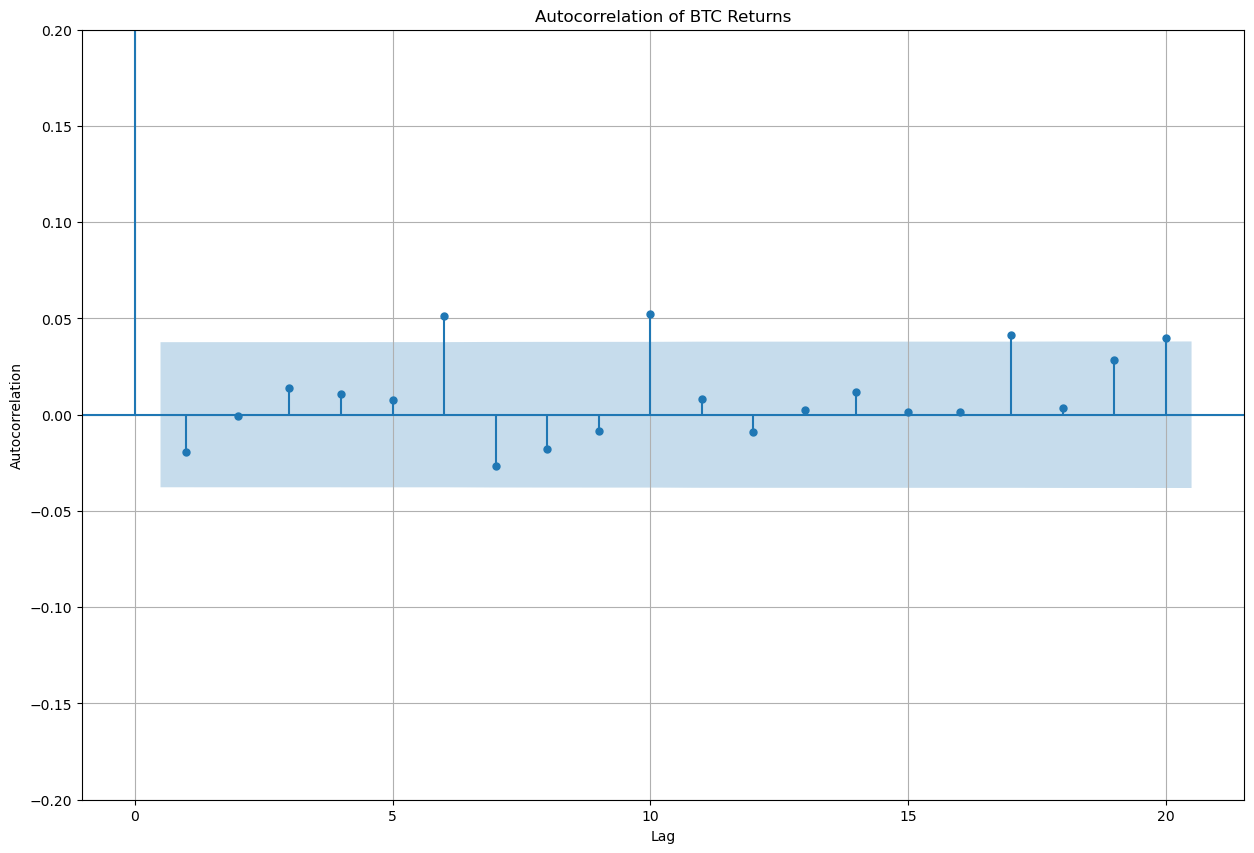

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sm.graphics.tsa.plot_acf(btc_rets, lags=20, ax=ax) # assuming 95% confidence interval for each lag time
plt.title('Autocorrelation of BTC Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
ax.set_ylim([-0.2, 0.2])
plt.grid(True)
plt.show()

- Other than the lag k=0, which exhibits autocorrelation of 1(which is to be expected), nearly all other lag times fall within the confidence bands of +/- 2/sqrt(n). This plot suggests that the autocorrelations of the 1-20 lag times are not statistically significant telling us that the returns of BTC do not show linear dependence on the past values(over the specified lag times). Essentially, the returns behave like a white noise which implies that simple linear model will not have good predictive power based on past returns alone. The ones that **do** fall outside the confidence interval, are not significant enough to conclude their is statistically significant autocorrelation for these lag times. **Ultimately we fail to reject the null hypothesis of zero-autocorrelation.**

**Part 2:**  

Use Monte‐Carlo method to price the following European Options by sampling in:

- **(a)** terminal stock price, $S_T$, which follows a lognormal distribution

- **(b)** log of terminal stock price, 
  $
    X_T = \ln\!\bigl(\tfrac{S_T}{S_0}\bigr),
  $
  which follows a normal distribution

- **(c)** CDF space: 
  $
    Y_T = F(X_T) 
    \;=\; \int_{-\infty}^{X_T} p(x)\,dx,
  $
  which follows a uniform distribution in $[0,1]$


### 1. Call option
$(S, K, T, \sigma, r, d) = (100,\,100,\,1,\,0.3,\,0,\,0)$  

Check your result against the analytical result.

---

### 2. Digital call option
$(S, K, T, \sigma, r, d) = (100,\,100,\,1,\,0.3,\,0,\,0)$  

A digital call option pays $1 at expiry if the underlying price is greater than the strike price.


In [15]:
# define parameters for both vanilla and digital call options
S0 = 100
K = 100
T = 1
sigma = 0.3
r = 0.0 
d = 0.0
nsims = 100000

In [16]:
# function for analytical B-S formula for vanilla and digital
def bs_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    return call_price

def bs_digital_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    digital_call_price = np.exp(-r * T) * stats.norm.cdf(d2)
    return digital_call_price

call_price_bs = bs_call_price(S0, K, T, r, sigma)
digital_call_price_bs = bs_digital_call_price(S0, K, T, r, sigma)

a) sampling the terminal stock price S_T directly (lognormal distribution)

In [17]:
# generate the random draws

# Z ~ N(0,1)
Z = np.random.normal(0,1,nsims)

# compute terminal stock price S_T
S_T = S0 * np.exp((r-d-0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)

# compute payoffs for both plain vanilla and digital call
vanilla_payoff = np.maximum(S_T - K,0)
digital_payoff = (S_T > K).astype(float)

discount_factor = np.exp(-r*T)

vanilla_price_a = discount_factor * vanilla_payoff.mean()
digital_price_a = discount_factor * digital_payoff.mean()

print(f'Vanilla Call Price(MC)(a): {vanilla_price_a}')
print(f'Digital Call Price(MC)(a): {digital_price_a}')
print()
print(f'Vanilla Call Price(Analytical): {call_price_bs}')
print(f'Digital Call Price(Analytical): {digital_call_price_bs}')

Vanilla Call Price(MC)(a): 11.897407765294423
Digital Call Price(MC)(a): 0.4415

Vanilla Call Price(Analytical): 11.923538474048499
Digital Call Price(Analytical): 0.4403823076297575


- The Monte Carlo method to price the Call options by sampling in the terminal stock price, S_T which follows a lognormal distribtuion is very close to the analytical pricing using B-S formula

**(b)** sampling  in log of terminal stock price, 
  $
    X_T = \ln\!\bigl(\tfrac{S_T}{S_0}\bigr),
  $
  which follows a normal distribution

In [18]:
Z = np.random.normal(0,1,nsims)

X_T = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z
S_T = S0 * np.exp(X_T)

vanilla_payoff_b = np.maximum(S_T - K, 0)
digital_payoff_b = (S_T > K).astype(float)

discount_factor = np.exp(-r * T)

call_price_b = discount_factor * vanilla_payoff_b.mean()
digital_price_b = discount_factor * digital_payoff_b.mean()

print(f'Vanilla Call Price(MC)(b): {call_price_b}')
print(f'Digital Call Price(MC)(b): {digital_price_b}')
print()
print(f'Vanilla Call Price(Analytical): {call_price_bs}')
print(f'Digital Call Price(Analytical): {digital_call_price_bs}')

Vanilla Call Price(MC)(b): 11.90620592431116
Digital Call Price(MC)(b): 0.43929

Vanilla Call Price(Analytical): 11.923538474048499
Digital Call Price(Analytical): 0.4403823076297575


- **(c)** CDF space: 
  $
    Y_T = F(X_T) 
    \;=\; \int_{-\infty}^{X_T} p(x)\,dx,
  $
  which follows a uniform distribution in $[0,1]$

In [19]:
# Y~U(0,1)
# then invert normal CDF for X_T = ln(S_T/S0)
Y = np.random.uniform(0,1,nsims)
mu = (r - 0.5 * sigma**2) * T
sigmaT = sigma * np.sqrt(T)

In [20]:
# inverting the cdf of the std normal 
# norm.ppf(Y) = inverse of phi(Y)
# X_T = mu + sigmaT * phi^-1(Y)
X_T = mu + sigmaT * norm.ppf(Y)

In [21]:
S_T = S0 * np.exp(X_T)

vanilla_payoff_c = np.maximum(S_T - K, 0)
digital_payoff_c = (S_T > K).astype(float)

call_price_c = discount_factor * vanilla_payoff_c.mean()
digital_price_c = discount_factor * digital_payoff_c.mean()

print(f'Vanilla Call Price(MC)(c): {call_price_c}')
print(f'Digital Call Price(MC)(c): {digital_price_c}')
print()
print(f'Vanilla Call Price(Analytical): {call_price_bs}')
print(f'Digital Call Price(Analytical): {digital_call_price_bs}')

Vanilla Call Price(MC)(c): 11.86271842431468
Digital Call Price(MC)(c): 0.4397

Vanilla Call Price(Analytical): 11.923538474048499
Digital Call Price(Analytical): 0.4403823076297575


All 3 sampling methods converge to similar Monte Carlo prices. They all end up producing the same lognormal distribution for S_T. When the number of simulations is high enough, the LLN causes the sample average of the disocunted payoff to be ~equal under the RN measure.